It is possible for a neural network to find the inverse of a matrix. One way to do this is to use an autoencoder, which is a type of neural network that is trained to reconstruct its input data from a lower-dimensional representation. This can be used to learn the inverse mapping from the output of the matrix to the input, which is effectively the inverse of the matrix. Another option is to use a recurrent neural network (RNN) or a long short-term memory (LSTM) network, which can learn to perform sequence-to-sequence mapping tasks such as matrix inversion. In both cases, the neural network would need to be trained on a dataset of input-output pairs, where the inputs are matrices and the outputs are their inverses.

In [2]:
from ComplexNetworks import Encoder,Decoder
import torch
import torch.nn as nn
import os 
import sys
from  tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
main_path =  os.getcwd()+"/../../"
sys.path.insert(0, main_path+"conf")
sys.path.insert(0, main_path+"controllers")
from config import *
from Constants import *
from Recieved import RX
sys.path.insert(0, main_path+"tools")
from utils import vector_to_pandas ,get_time_string



In [20]:
def Complex_MSE(output,target):
    return torch.sum((target-output).abs())

def Complex_MSE_polar(output,target):
    return torch.sum(torch.log(torch.pow(output.abs()/target.abs(),2))+torch.pow(output.angle()-target.angle(),2))

### Define the loss function
loss_fn = Complex_MSE

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.0001

### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
d = 48

#model = Autoencoder(encoded_space_dim=encoded_space_dim)
encoder = Encoder(encoded_space_dim=d)
decoder = Decoder(encoded_space_dim=d)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr,weight_decay=1e-4)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)
#load data with QAM 16
data   = RX(4,"Unit_Pow")

#standarize data
mean_H, std_H = np.mean(data.H), np.std(data.H)
data.H = (data.H-mean_H)/std_H

#normalize data
normalize_factor_H = np.max(np.abs(data.H))
data.H   = data.H / normalize_factor_H


#save invsere in memory
H_inv = np.zeros(data.H.shape,dtype=data.H.dtype)
loop  = tqdm(range(0,data.total),desc="Progress")
for i in loop:
    H_inv[:,:,i] = np.linalg.inv(data.H[:,:,i])

#standarize 
mean_H_inv, std_H_inv = np.mean(H_inv), np.std(H_inv)
H_inv = (H_inv-mean_H_inv)/std_H_inv

#Normalize inverse
# save this as variable because we will use it from denormalize
normalize_factor = np.max(np.abs(H_inv)) 
H_inv = H_inv / normalize_factor



# Set train mode for both the encoder and the decoder
encoder.train()
decoder.train()
train_loss = []

Selected device: cuda


Progress: 100%|██████████| 20000/20000 [00:01<00:00, 11476.65it/s]


In [78]:
#TRAIN
for EPOCHS in range(0,30):
    print("EPOCH {}".format(EPOCHS))
    # Generate a random permutation of the indices along the third axis
    permutation = np.random.permutation(data.H.shape[2])
    data.H = data.H[:, :, permutation]
    
    loop  = tqdm(range(0,int(data.total*.6)),desc="Progress")
    for i in loop:
        H = data.H[:,:,i]
        #autoenconder Input
        chann = torch.from_numpy(H).to(device)
        chann = chann[None,None,:,:]
        #### Encode decode
        z = encoder(chann)
        decoded_image = decoder(z)
        
        #Channel inverse matrix
        I = torch.from_numpy(H_inv[:,:,i]).to(device)
        # Evaluate loss
        
        loss = loss_fn(I, decoded_image)

        # Backward pass
        optim.zero_grad()
        loss.backward()
        optim.step()
        if(i % 20 == 0):
            loop.set_description(f"EPOCH[{EPOCHS}]")
            loop.set_postfix(loss=loss.cpu().detach().numpy())

EPOCH 0


EPOCH[0]: 100%|██████████| 12000/12000 [04:45<00:00, 42.08it/s, loss=0.14039811] 


EPOCH 1


EPOCH[1]: 100%|██████████| 12000/12000 [05:00<00:00, 39.89it/s, loss=0.11261752] 


EPOCH 2


EPOCH[2]: 100%|██████████| 12000/12000 [04:55<00:00, 40.55it/s, loss=0.13312039] 


EPOCH 3


EPOCH[3]: 100%|██████████| 12000/12000 [05:01<00:00, 39.86it/s, loss=0.11097385] 


EPOCH 4


EPOCH[4]: 100%|██████████| 12000/12000 [04:53<00:00, 40.87it/s, loss=0.10970221] 


EPOCH 5


EPOCH[5]: 100%|██████████| 12000/12000 [04:51<00:00, 41.19it/s, loss=0.11767311] 


EPOCH 6


EPOCH[6]: 100%|██████████| 12000/12000 [05:00<00:00, 39.92it/s, loss=0.09732564] 


EPOCH 7


EPOCH[7]: 100%|██████████| 12000/12000 [04:54<00:00, 40.79it/s, loss=0.102994576]


EPOCH 8


EPOCH[8]: 100%|██████████| 12000/12000 [04:49<00:00, 41.51it/s, loss=0.12268012] 


EPOCH 9


EPOCH[9]: 100%|██████████| 12000/12000 [04:55<00:00, 40.55it/s, loss=0.10752068] 


EPOCH 10


EPOCH[10]: 100%|██████████| 12000/12000 [05:01<00:00, 39.83it/s, loss=0.090522304]


EPOCH 11


EPOCH[11]: 100%|██████████| 12000/12000 [05:03<00:00, 39.58it/s, loss=0.120318435]


EPOCH 12


EPOCH[12]: 100%|██████████| 12000/12000 [05:01<00:00, 39.76it/s, loss=0.09852505] 


EPOCH 13


EPOCH[13]: 100%|██████████| 12000/12000 [04:47<00:00, 41.68it/s, loss=0.10552707] 


EPOCH 14


EPOCH[14]: 100%|██████████| 12000/12000 [05:01<00:00, 39.78it/s, loss=0.089914955]


EPOCH 15


EPOCH[15]: 100%|██████████| 12000/12000 [04:57<00:00, 40.38it/s, loss=0.0986353]  


EPOCH 16


EPOCH[16]: 100%|██████████| 12000/12000 [04:42<00:00, 42.50it/s, loss=0.13577673] 


EPOCH 17


EPOCH[17]: 100%|██████████| 12000/12000 [04:55<00:00, 40.63it/s, loss=0.11031553] 


EPOCH 18


EPOCH[18]: 100%|██████████| 12000/12000 [05:04<00:00, 39.35it/s, loss=0.10978294] 


EPOCH 19


EPOCH[19]: 100%|██████████| 12000/12000 [05:01<00:00, 39.85it/s, loss=0.12832096] 


EPOCH 20


EPOCH[20]: 100%|██████████| 12000/12000 [04:50<00:00, 41.31it/s, loss=0.11790367] 


EPOCH 21


EPOCH[21]: 100%|██████████| 12000/12000 [04:54<00:00, 40.81it/s, loss=0.1616687]  


EPOCH 22


EPOCH[22]: 100%|██████████| 12000/12000 [04:52<00:00, 41.06it/s, loss=0.11791411] 


EPOCH 23


EPOCH[23]: 100%|██████████| 12000/12000 [04:50<00:00, 41.27it/s, loss=0.11854607] 


EPOCH 24


EPOCH[24]: 100%|██████████| 12000/12000 [04:52<00:00, 41.06it/s, loss=0.09386413] 


EPOCH 25


EPOCH[25]: 100%|██████████| 12000/12000 [04:54<00:00, 40.69it/s, loss=0.09385705] 


EPOCH 26


EPOCH[26]: 100%|██████████| 12000/12000 [04:59<00:00, 40.11it/s, loss=0.10400772] 


EPOCH 27


EPOCH[27]: 100%|██████████| 12000/12000 [04:54<00:00, 40.73it/s, loss=0.103920594]


EPOCH 28


EPOCH[28]: 100%|██████████| 12000/12000 [04:52<00:00, 41.01it/s, loss=0.08222137] 


EPOCH 29


EPOCH[29]: 100%|██████████| 12000/12000 [04:48<00:00, 41.64it/s, loss=0.09240092] 


In [79]:
#TEST    
encoder.eval()
decoder.eval() 
loop  = tqdm(range(int(data.total*.6),data.total),desc="Progress")
with torch.no_grad():
    input_image = []
    recon_image = []
    for i in loop:
        #autoenconder Input
        chann = torch.from_numpy(data.H[:,:,i]).to(device)
        chann = chann[None,None,:,:]
        #### Encode decode
        z = encoder(chann)
        decoded_image = decoder(z)
        
        #Channel inverse matrix
        I = torch.from_numpy(H_inv[:,:,i]).to(device)
    
        val_loss = loss_fn(I, decoded_image)
        #print loss
        if(i % 50 == 0):
            loop.set_postfix(loss=val_loss.cpu().detach().numpy())
            
        #Append overall
        recon_image.append(decoded_image.cpu()) # AUtoenconder output
        input_image.append(chann.cpu()) # Autoenconder input
        
    input_image = torch.cat(input_image)
    recon_image = torch.cat(recon_image) 
        
    val_loss = loss_fn(input_image, recon_image)

Progress: 100%|██████████| 8000/8000 [00:35<00:00, 227.84it/s, loss=0.08665614] 


In [92]:
sns.set_theme()
H = data.H[:,:,10000]
#autoenconder Input
chann = torch.from_numpy(H).to(device)
chann = chann[None,None,:,:]
#### Encode decode
z = encoder(chann)
decoded_image = decoder(z)

#Channel inverse matrix
I = torch.from_numpy(H_inv[:,:,10001]).to(device)
# Evaluate loss

loss = loss_fn(I, decoded_image)
print(loss)


tensor(0.2318, device='cuda:0', grad_fn=<SumBackward0>)


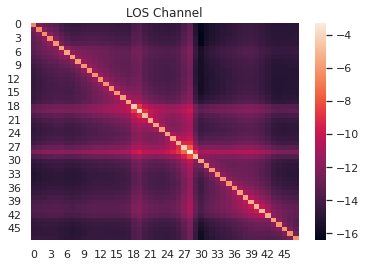

In [90]:

I = np.squeeze(I.cpu().detach().numpy())
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(np.log(np.abs(I)))
#sns.heatmap(chann.real)
plt.title( "LOS Channel" )
plt.show()



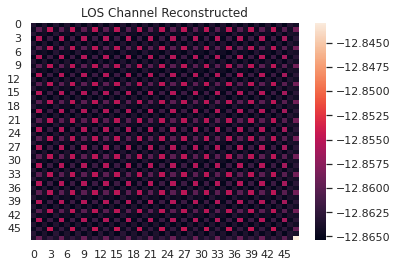

In [93]:
decoded_image = np.squeeze(decoded_image.cpu().detach().numpy())
sns.heatmap(np.log(np.abs(decoded_image)))
plt.title( "LOS Channel Reconstructed" )
plt.show()


In [53]:
np.squeeze(decoded_image).shape

(48, 48)

Test BER with dimensionality reduction of the channel 

In [45]:
def LMSE(H,Y,SNR):
    return Y*1/H

BER    = []
for SNR in range(GOLDEN_BEST_SNR,GOLDEN_WORST_SNR-1,-1*GOLDEN_STEP):
        loop  = tqdm(range(int(data.total*.6),data.total),desc="Progress")
        errors = 0
        data.AWGN(SNR)
        for i in loop:
            #Get realization
            Y = data.Qsym.r[:,i]        
            H = data.H[:,:,i]
            #autoenconder Input
            chann   = torch.from_numpy(H).to(device)
            chann = chann[None,None,:,:]
            #### Encode decode
            z = encoder(chann)
            decod = decoder(z)
            decoded_image = np.squeeze(decod.cpu().detach().numpy())
            H_inv = decoded_image*normalize_factor
            X_hat = H_inv@Y
            #X_hat  = LMSE(H_vect.T,Y,SNR)
            
            txbits = np.squeeze(data.Qsym.bits[:,i],axis=1)
            rxbits = data.Qsym.Demod(X_hat)
            errors+=np.unpackbits((txbits^rxbits).view('uint8')).sum()
            
            #Status bar and monitor  
            if(i % 100 == 0):
                loop.set_description(f"SNR [{SNR}]")
                loop.set_postfix(ber=errors/((data.bitsframe*data.sym_no)*(data.total*.4)))
                
        BER.append(errors/((data.bitsframe*data.sym_no)*(data.total*.4)))
        
vector_to_pandas("BER_SNR{}.csv".format(get_time_string()),BER)

SNR [43]:  17%|█▋        | 1325/8000 [00:08<00:43, 154.91it/s, ber=0.0813]


KeyboardInterrupt: 